In [1]:
from __future__ import print_function, division

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import qgrid

import numpy as np
from numpy import diff
import math

import pandas as pd
import xarray as xr

import climlab
from climlab.solar.insolation import daily_insolation
from climlab.radiation import DailyInsolation
from climlab.radiation import FixedInsolation
from climlab.process import TimeDependentProcess
from climlab.utils import heat_capacity
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

from IPython.display import HTML


import scipy as scp
from attrdict import AttrDict
from datetime import datetime

import dask.dataframe as dd

import warnings

import util
import ram_model
import plotting

## Data

Read data and concatenate into one dataset.

level 0 = Surface

level 110 = TOA

(our data is in the order TOA-->Surface)

In [3]:
ds = util.load_soundings()
util.add_monthly_insolation(ds)
ds = util.adjust_lev(ds, nlevels = 95)
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


Dropped levels [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 14, 15, 17, 18, 20, 22, 24, 26]


# Climlab

All tendencies must be in K/sec (see Climlab energy_budget documentation and self.heating_rate attribute): https://climlab.readthedocs.io/en/latest/_modules/climlab/process/energy_budget.html#EnergyBudget

In [4]:
timestep = 3600 #seconds

############# FIND OUR AVERAGE KAPPA AND ADVECTION ###############

#### Find the surface diffk average over 12 months at CO2 = .00038 ####
mean_diffk_dict = {}
mean_diffk_dict = ram_model.fill_ensemble(ds, mean_diffk_dict, timestep, 
                                                     advection_on = True, turbulence_on = True, 
                                                     advection = None, 
                                                     surface_diffk = None)
surface_diffk_average = ram_model.annual_mean_sfc_diffk(ds, mean_diffk_dict)
print(surface_diffk_average)

#### Find our initial advection #### 
adv_dict = {}
adv_dict = ram_model.fill_ensemble(ds, adv_dict, timestep, 
                                   advection_on = True, turbulence_on = True, 
                                   advection = None, 
                                   surface_diffk = surface_diffk_average)
advection_380_monthly = {}
for m in months:
    advection_380_monthly[m] = adv_dict[0.00038][m].subprocess.Advection.forcing_tendencies['Tatm']
    
############# CREATE OUR MODELS ############    
#### Use our initial advection and surface diffk to run the model #### 

########### RADIATIVE ADVECTIVE TURBULENT #############
rat_dict = {}
rat_dict = ram_model.fill_ensemble(ds, rat_dict, timestep, 
                                   advection_on = True, turbulence_on = True, 
                                   advection = advection_380_monthly,
                                   surface_diffk = surface_diffk_average)



/Users/lyssafreese/Documents/code/antarctic_rad/notebooks/ram_model.py:115: UserWarning: CFL Condition not met, [1.24795238], timestep too large or lower level z difference too small for January, CO2 kg/kg
  warnings.warn(f"CFL Condition not met, {self._CFL}, timestep too large or lower level z difference too small for {self.m}, CO2 kg/kg")


[0.35573846]


In [5]:
########### RADIATIVE ADVECTIVE #############
ra_dict = {}
ra_dict = ram_model.fill_ensemble(ds, ra_dict, timestep, 
                                   advection_on = True, turbulence_on = False, 
                                   advection = advection_380_monthly,
                                   surface_diffk = surface_diffk_average)



In [6]:
########### RADIATIVE TURBULENT #############
rt_dict = {}
rt_dict = ram_model.fill_ensemble(ds, rt_dict, timestep, 
                                   advection_on = False, turbulence_on = True, 
                                   advection = None,
                                   surface_diffk = surface_diffk_average)

# Output (initial and over time)

In [7]:
#setup dicts and steps for time
month_ds_dict = {} #Empty dictionary to add values into
steps = 3650 #steps forward
fields_dict = {'TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds'} #field outputs from climlab
model_dict = {'rat':rat_dict, #dict of the models we are running (r = rad, a= adv, t= turb)
             'rt':rt_dict,
             'ra':ra_dict}

In [8]:
#original output
ex_dict = rat_dict.copy() #create a reference dict
for month in months:
    #create a dict of datasets for each month
    month_ds_dict[month] = xr.Dataset(data_vars = {
                                    'model' : ('model', ['rat','rt','ra']),
                                    'co2_lev': ('co2_lev', ds['CO2_list'].values), 
                                    'time': ('time', np.arange(0,((steps+1)*timestep),timestep)),
                                    'lev': ('lev', ex_dict[.00038][month].lev),
                                    'lev_full': ('lev_full', np.append(ex_dict[.00038][month].lev, 
                                                                       ex_dict[.00038][month].lev[-1]+(ex_dict[.00038][month].lev[-1]-ex_dict[.00038][month].lev[-2]))),
                                    'lev_bounds': ('lev_bounds', ex_dict[.00038][month].lev_bounds)
                                    })
    #create a data array for each type of level (bounds, lev, and lev_full which includes the ground)
    lev_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'],month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev','time')
                    )


    lev_bounds_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'], month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev_bounds'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev_bounds'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev_bounds','time')
                    )
    lev_full_da = xr.DataArray(
                        data = np.zeros((month_ds_dict[month].dims['model'], month_ds_dict[month].dims['co2_lev'],month_ds_dict[month].dims['lev_full'],month_ds_dict[month].dims['time'])), 
                        coords = ((month_ds_dict[month].coords['model'], month_ds_dict[month].coords['co2_lev'], month_ds_dict[month].coords['lev_full'], month_ds_dict[month].coords['time'])),
                        dims = ('model','co2_lev', 'lev_full','time')
                    )
    #assign a data array to each variable
    month_ds_dict[month]['T'] = lev_full_da.copy()
    month_ds_dict[month]['turb_hr'] = lev_full_da.copy()
    month_ds_dict[month]['turbulent_flux'] = lev_bounds_da.copy()
    month_ds_dict[month]['diffk'] = lev_bounds_da.copy()
    month_ds_dict[month]['theta_init'] = lev_da.copy()
    month_ds_dict[month]['theta'] = lev_da.copy()
    month_ds_dict[month]['turb_atm_hr'] = lev_da.copy()
    month_ds_dict[month]['advection'] = lev_full_da.copy()
    
    for var in fields_dict.keys():
        if fields_dict[var] == 'z':
            month_ds_dict[month][var] = lev_da.copy()
        if fields_dict[var] == 'z_bounds':
            month_ds_dict[month][var] = lev_bounds_da.copy()
            
    for co2 in ex_dict.keys():
        for dict_name in model_dict.keys():
            #assign the temperature variable
            month_ds_dict[month]['T'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].state['Tatm']),
                                                         np.array(model_dict[dict_name][co2][month].state['Ts']))
            
            #assign the variables in the 'advection' field
            if 'a' in dict_name:
                month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                         np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Ts']))
            #assign the variables in the 'turbulence' field
            if 't' in dict_name:
                month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['turb_atm_hr']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['turb_sfc_hr']))
                month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_turbulent_flux']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['sfc_turbulent_flux']))
                month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_diffk']),
                                                             np.array(model_dict[dict_name][co2][month].diagnostics['surface_diffk']))
                month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta_init'].to_xarray().data
                month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta'].to_xarray().data
                month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['turb_atm_hr'].to_xarray().data
            #assign the variables in the 'field dict' which are typical outputs from climlab
            for var in fields_dict.keys():
                month_ds_dict[month][var].loc[dict(co2_lev = co2, time = 0, model = dict_name)] = model_dict[dict_name][co2][month].diagnostics[var].to_xarray().data


In [ ]:
#timestepper
for month in months:
    for dict_name in model_dict.keys():
        for co2 in rat_dict.keys():
            for i in range(steps):
                #step the model forward
                model_dict[dict_name][co2][month].step_forward()
                #assign temperature
                month_ds_dict[month]['T'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].state['Tatm']),
                                                             np.array(model_dict[dict_name][co2][month].state['Ts']))
                #assign the variables in the 'field dict' which are typical outputs from climlab
                for var in fields_dict.keys():

                    month_ds_dict[month][var].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics[var].to_xarray().data


                #assign the variables in the 'advection' field
                if 'a' in dict_name:

                    month_ds_dict[month]['advection'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Tatm']),
                                                             np.array(model_dict[dict_name][co2][month].subprocess.Advection.forcing_tendencies['Ts']))
                #assign the variables in the 'turbulence field'
                if 't' in dict_name:
                   
                    month_ds_dict[month]['turb_hr'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['turb_atm_hr']),
                                                                 np.array(model_dict[dict_name][co2][month].diagnostics['turb_sfc_hr']))
                    month_ds_dict[month]['turbulent_flux'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_turbulent_flux']),
                                                                 np.array(model_dict[dict_name][co2][month].diagnostics['sfc_turbulent_flux']))
                    month_ds_dict[month]['diffk'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = np.append(np.array(model_dict[dict_name][co2][month].diagnostics['atm_diffk']),
                                                                 np.array(model_dict[dict_name][co2][month].diagnostics['surface_diffk']))
                    month_ds_dict[month]['theta_init'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta_init'].to_xarray().data
                    month_ds_dict[month]['theta'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['theta'].to_xarray().data
                    month_ds_dict[month]['turb_atm_hr'].loc[dict(co2_lev = co2, time = ((i+1)*timestep), model = dict_name)] = model_dict[dict_name][co2][month].diagnostics['turb_atm_hr'].to_xarray().data



In [ ]:
for month in months:
    for co2 in ex_dict.keys():
        for dict_name in model_dict.keys():
            #create z coords
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z = model_dict[dict_name][co2][month].z)
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z_bounds = model_dict[dict_name][co2][month].z_bounds)
            month_ds_dict[month] = month_ds_dict[month].assign_coords(z_full = np.append(model_dict[dict_name][co2][month].z, 0))

In [11]:
###create a dict of output names and the z bounds they align with
output_dict = {}
output_dict['bounds'] = {'Tatm':'z','TdotLW_clr':'z', 'LW_flux_up_clr':'z_bounds', 
               'LW_flux_down_clr':'z_bounds', 'LW_flux_net_clr':'z_bounds', 
               'TdotSW_clr':'z', 'SW_flux_up_clr':'z_bounds', 
               'SW_flux_down_clr':'z_bounds', 'SW_flux_net_clr':'z_bounds',
               'theta_init':'z', 'theta':'z', 'dtheta_dz':'z_bounds', 'atm_diffk':'z_bounds', 
               'atm_turbulent_flux':'z_bounds','turb_atm_hr':'z', 
               'turb_hr':'z', 'advection_Tatm':'z'}
atm_process_dict = {'Tatm':'Atmospheric Temperature (K)',
                    'atm_diffk':r'Atmospheric $\kappa$ ($\frac{m^2}{s}$)',
                    'dtheta_dz':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)',
                    'theta':r'$\theta$',
                    'SW_flux_net_clr':r'Shortwave Flux ($\frac{W}{m^2}$)',
                    'LW_flux_net_clr':r'Longwave Flux ($\frac{W}{m^2}$)', 
                    'TdotLW_clr':r'Longwave Heating Rate ($\frac{K}{s}$)',
                    'TdotSW_clr':r'Shortwave Heating Rate ($\frac{K}{s}$)',
                    'turb_atm_hr':r'Turbulent Heating Rate ($\frac{K}{s}$)',
                    'advection_Tatm':r'Advective Heating Rate ($\frac{K}{s}$)',
                   'atm_turbulent_flux':'Turbulent Flux'}
single_level_process = {'LW_sfc_clr':r'Surface Longwave Flux ($\frac{W}{m^2}$)', 
                        'Ts': 'Surface Temperature (K)', 
                        'ASRclr':r'Absorbed Solar Radiation, ($\frac{W}{m^2}$)', 
                        'SW_sfc_clr':r'Surface Shortwave Flux ($\frac{W}{m^2}$)', 
                        'total_sfc_flux':r'Total Surface Flux ($\frac{W}{m^2}$)', 
                        'dtheta_dz_near_surf_init':r'$\frac{d\theta}{dz}$ ($\frac{K}{m}$)', 
                        'surface_diffk':r'Surface $\kappa$ ($\frac{m^2}{s}$)', 
                        'sfc_turbulent_flux':r'Surface Turbulent Flux ($\frac{W}{m^2}$)', 
                        'turb_sfc_hr':r'Surface Turbulent Heating Rate ($\frac{K}{s}$)', 
                        'advection_Ts':r'Surface Advection ($\frac{K}{s}$)', 
                        'OLR':r'Outgoing Longwave Radiation ($\frac{W}{m^2}$)'}

#### parameters for plots

In [187]:
###select CO2 concentrations and times to look at
CO2_conc1 = .00038
CO2_conc2 = .00076
time1 = (0)*timestep
time2 = 2*365*timestep
time3 = 4*365*timestep
time4 = 5*365*timestep
time5 = 7*365*timestep
time6 = 9*365*timestep
time7 = 10*365*timestep
month1 = 'December'
month2 = 'June'

#### CO2 difference plots

['atm_diffk','Tatm','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','turb_atm_hr','advection_Tatm']

plotting.plot_co2_dif(
        results_dict, 
        output = 'Tatm',
        output_dict = results_dict, month_list = ['December','June'], CO2_conc1 = CO2_conc1,CO2_conc2 = CO2_conc2, 
        time1 = time7,figsize = [8,4], rows =5, columns =2, ylim = 700, diff_only = True
    )
#plt.savefig(f'../figures/temp_evolution.png', bbox_inches = 'tight', dpi = 150)

#### time difference plots

['Tatm','atm_diffk','dtheta_dz','theta','SW_flux_net_clr','LW_flux_net_clr','TdotLW_clr','TdotSW_clr','turb_atm_hr','advection_Tatm', 'atm_turbulent_flux']:


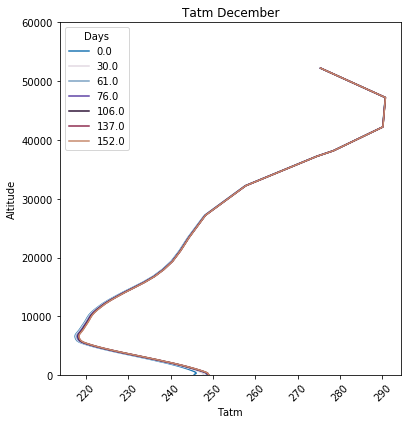

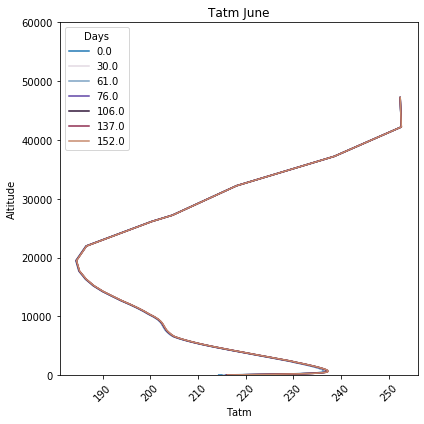

In [188]:
for output in ['Tatm']:
    for month in [month1, month2]:
        plotting.plot_time_dif(
            results_dict,
            output = output,
            output_dict = output_dict, CO2_conc1 = CO2_conc1, time1 = 0, timesteps = [time2, time3, time4, time5, time6, time7], month = month,
            figsize = [6,6], ylim = 60000, diff_only = False
                               )
        plt.title(f'{output} {month}')
#plt.savefig(f'../figures/{month}_time_dif_1000m.png', bbox_inches = 'tight', dpi = 150)

#### look at Tatm lowest level - Ts 

NameError: name 'colors' is not defined

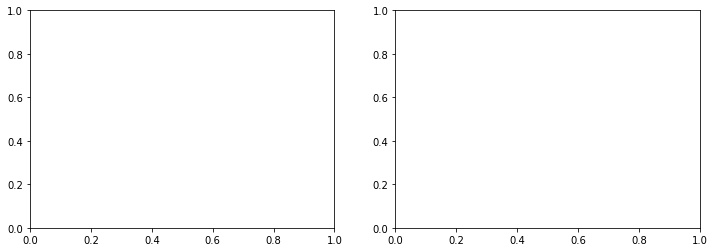

In [189]:
#### plot the density of the atmosphere (which is used to calculate the advective flux)
R = 8.314 #J/mol/K
MW_air = 0.0289647 #kg/mol
cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
month_list = ['December','June']
figsize = [12,4]
t = time7
fig, axes = plt.subplots(1, len(month_list), figsize = figsize)
for idx_m, month in enumerate(month_list):
    ax = axes[idx_m]
    density_atm1 = (MW_air*100*ram_dict[CO2_conc1][month].lev)/(np.asarray(results_dict[t]['Tatm'][CO2_conc1][month]) * R) #kg/m^3
    pressure_TOA1 = ram_dict[CO2_conc1][month].lev #hPa
    ax.plot(density_atm1, pressure_TOA1, c = colors[1], marker = '.', linestyle = '')

    density_atm2 = (MW_air*100*ram_dict[CO2_conc2][month].lev)/(np.asarray(results_dict[t]['Tatm'][CO2_conc2][month]) * R) #kg/m^3
    pressure_TOA2 = ram_dict[CO2_conc2][month].lev #hPa
    ax.plot(density_atm2, pressure_TOA2, c = colors[2], marker = '.', linestyle = '')
    ax.set_ylim(700,-10)
    ax.set_ylabel('Pressure [hPa]')
    ax.set_xlabel('Density [kg/m3]')

#### plot entire column (surface + atmosphere)

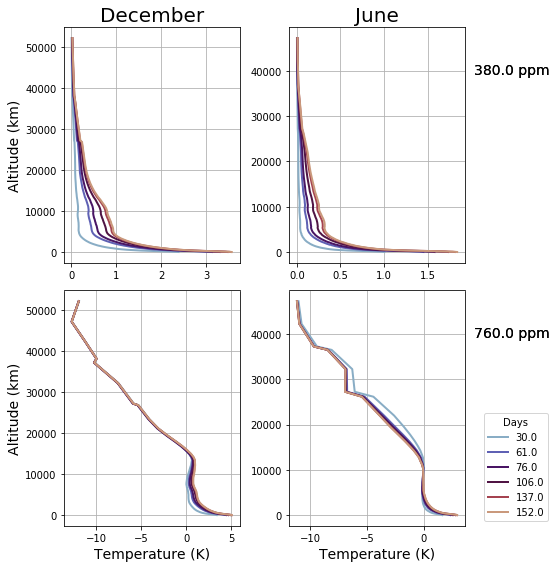

In [52]:
#### plot the temperature timestepped forward
plotting.plot_temp_timestepped(ds, results_dict, month1, month2, time1, [time2, time3, time4, time5, time6, time7], 
                               ylim = 60000, diff_only = True)
#plt.savefig('../figures/temp_evolution.png', bbox_inches = 'tight',dpi = 150)


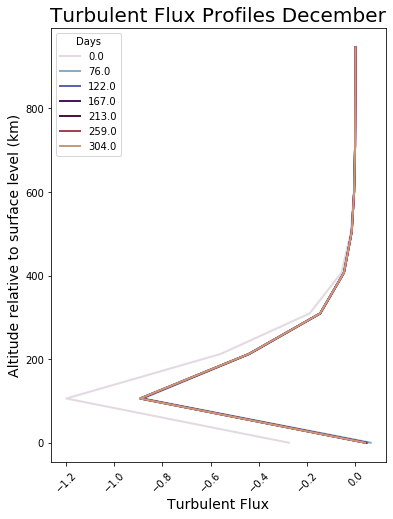

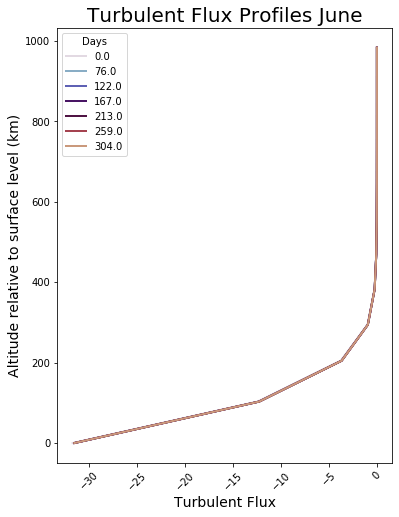

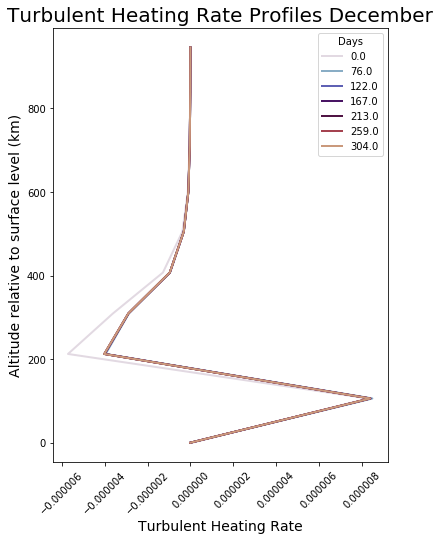

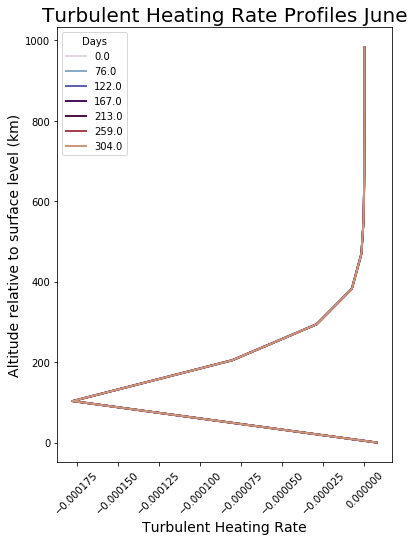

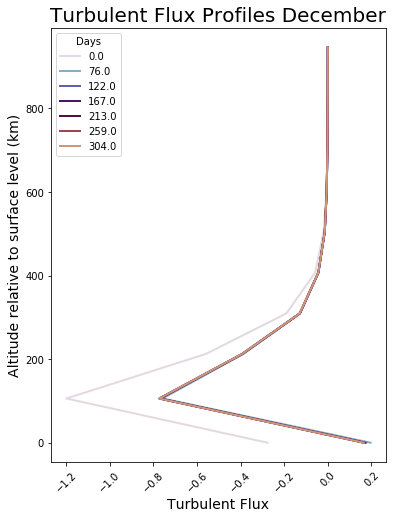

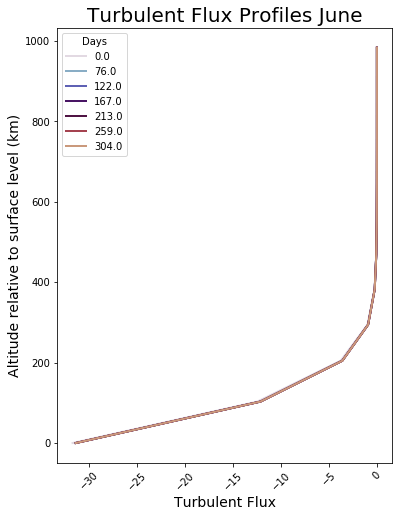

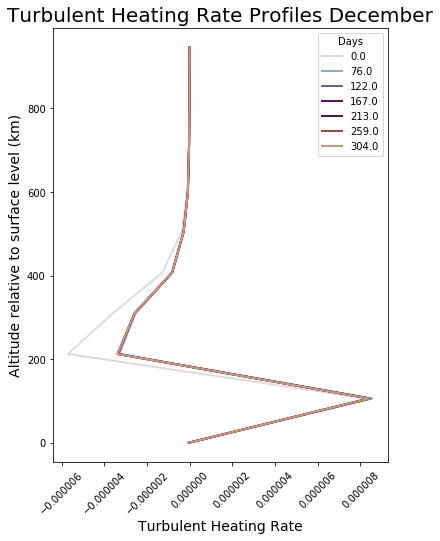

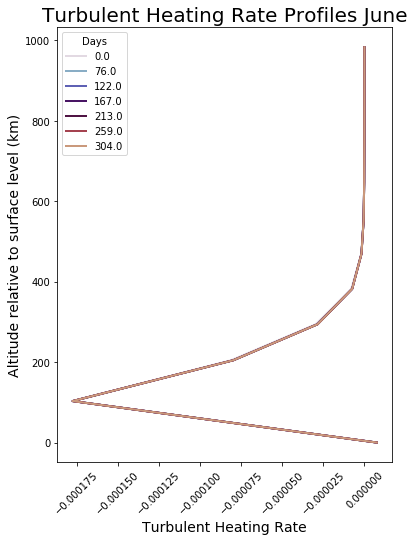

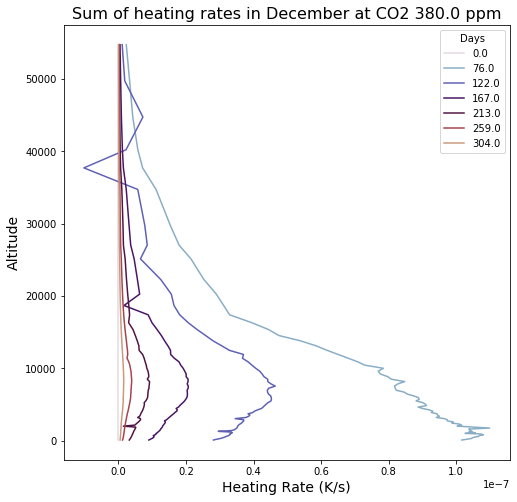

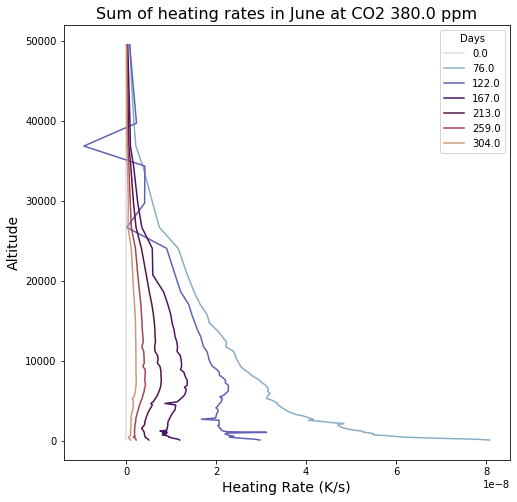

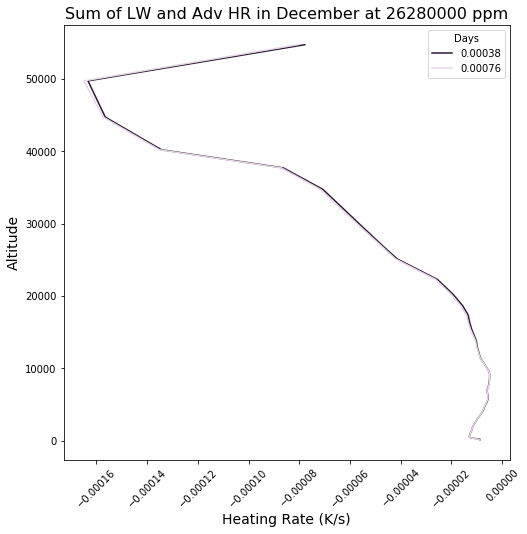

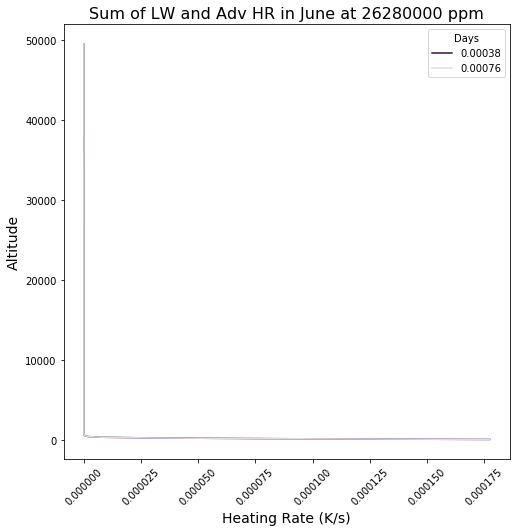

In [44]:

#### plot the turbulent flux and turbulent heating rates (surface and atmosphere)
for CO2 in [.00038, .00076]:
    for month in [month1,month2]:
        plotting.plot_turbulent_flux(ds, results_dict, month, CO2, [time1, time2, time3, time4, time5, time6, time7], ylim = 1000)
    for month in [month1,month2]:  
        plotting.plot_turbulent_hr(ds, results_dict, month, CO2, [time1, time2, time3, time4, time5, time6, time7], ylim = 1000)
#### plot the total heating rate over time
for month in [month1,month2]:
    plotting.plot_sum_hr(results_dict, month, .00038,[time1, time2, time3, time4, time5, time6, time7])
#### plot just the advection and LW heating rates
for month in [month1,month2]:
    plotting.plot_adv_LW_hr(results_dict, month, .00038, .00076, time7, diff_only =False)

#### single level process plots: 

NameError: name 'rad_sfc_HR' is not defined

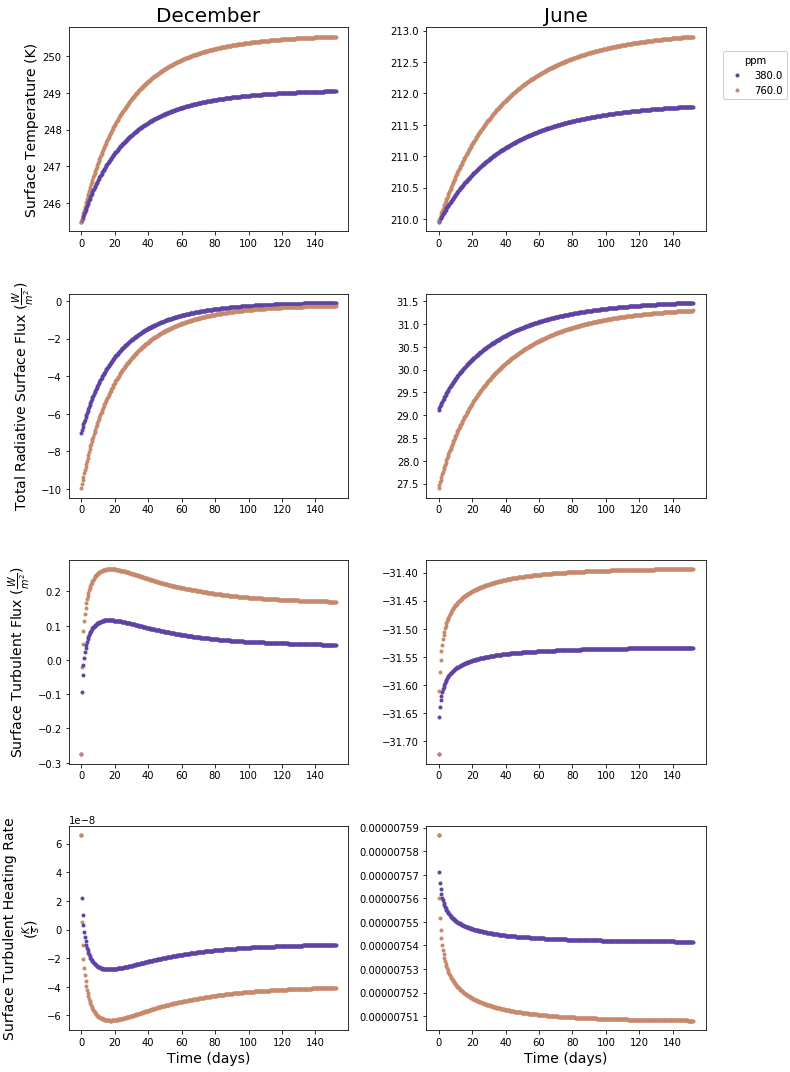

In [184]:
#### plot the surface processes
plotting.single_level_plot(results_dict,['Ts', 'total_sfc_flux', 'sfc_turbulent_flux', 'turb_sfc_hr'], 
                           CO2_conc1, CO2_conc2, [month1,month2], figsize = [10,15])
#plt.savefig(f'../figures/surface_processes.png', bbox_inches = 'tight', dpi = 150)
#### plot the surface radiative heating rate
plotting.rad_sfc_HR_plot(rad_sfc_HR,results_dict, .00038, .00076, ['December','June'], [10,4])

In [186]:
#### plot the advection+ ASR vs OLR
month_list = ['December','June']
fig, axes = plt.subplots(1, len(month_list), figsize = figsize)
colors = cm.twilight(np.linspace(0,1,7))
for idx_m, month in enumerate([month_list]):
    ax = axes[idx_m]
    #plot the OLR
    for t in list(results_dict.keys())[0::10]:
            ax.plot(t / climlab.constants.seconds_per_day,results_dict[t]['OLR'][CO2_conc1][month], c = colors[2], marker = '.', linestyle = '')
            ax.plot(t / climlab.constants.seconds_per_day,results_dict[t]['OLR'][CO2_conc2][month], c = colors[5], marker = '.', linestyle = '')
    #plot the sum of advection and ASR
    for t in list(results_dict.keys())[0::150]:
        #advection
        pressure_TOA1 = 100*ram_dict[CO2_conc1][month].lev[-1] #pascal (kg/m/s2)
        density_atm1 = (MW_air*100*ram_dict[CO2_conc1][month].lev)/(np.asarray(results_dict[t]['Tatm'][CO2_conc1][month]) * R) #kg/m^3
        delta_z1 = np.diff(results_dict[t]['z_bounds'][CO2_conc1][month]) #surface to atmosphere #m
        heat_capacity_atm1 = density_atm1*cp_air
        total_adv_flux1 = np.asarray(results_dict[t]['advection_Tatm'][CO2_conc1][month]) * heat_capacity_atm1* delta_z1 #W/m2
        ADV1 = total_adv_flux1.sum()
        #ASR
        ASR1= results_dict[t]['ASR'][CO2_conc1][month]
        #plot
        ax.plot(t / climlab.constants.seconds_per_day,ASR1-ADV1, c = colors[2], marker = '.', linestyle = '')
    for t in list(results_dict.keys())[75::150]:
        #advection
        pressure_TOA2 = 100*ram_dict[CO2_conc1][month].lev[-1] #pascal (kg/m/s2)
        density_atm2 = (MW_air*100*ram_dict[CO2_conc1][month].lev)/(np.asarray(results_dict[t]['Tatm'][CO2_conc1][month]) * R) #kg/m^3
        delta_z2 = np.diff(results_dict[t]['z_bounds'][CO2_conc1][month]) #surface to atmosphere #m
        heat_capacity_atm2 = density_atm2*cp_air
        total_adv_flux2 = np.asarray(results_dict[t]['advection_Tatm'][CO2_conc2][month]) * heat_capacity_atm2 * delta_z2 #W/m2
        ADV2 = total_adv_flux2.sum()
        #ASR
        ASR2= results_dict[t]['ASR'][CO2_conc2][month]
        #plot
        ax.plot(t / climlab.constants.seconds_per_day,ASR2-ADV2, c = colors[5], marker = '.', linestyle = '')
    axes[idx_m].set_xlabel('Time (days)', fontsize = 14)
    axes[0].set_ylabel(r'$\frac{W}{m^2}$', fontsize = 14, wrap=True)
    axes[idx_m].set_title(month, fontsize = 20)
plt.legend([f'{CO2_conc1*(1e6)}',f'{CO2_conc2*(1e6)}'], title = 'ppm', bbox_to_anchor=(1.05, 1.0))

legend_elements = [Line2D([0], [0], lw=4, color = 'C7', label='OLR'),
                   Line2D([0], [0], marker='o', color = 'C7', label='ASR + Advection',
                           markersize=5, linestyle="None")]
leg = Legend(ax, handles=legend_elements, labels = ['OLR', 'ASR + Advection'], bbox_to_anchor=(1.47, .75))
ax.add_artist(leg);
#plt.savefig('../figures/ASR_OLR.png', bbox_inches = 'tight', dpi = 150)

NameError: name 'figsize' is not defined

### find entire column energy balance

In [160]:
#time we're looking at
time = time7-3600
month = month1

In [161]:

#TOA Frad
F_rad_toa = np.asarray(results_dict[time]['ASR'][CO2_conc1][month]) - np.asarray(results_dict[time]['OLR'][CO2_conc1][month]) #W/m2

#Surface Frad
F_rad_sfc = np.asarray(results_dict[time]['SW_sfc_clr'][CO2_conc1][month]) - np.asarray(results_dict[time]['LW_sfc_clr'][CO2_conc1][month]) #W/m2

#Surface Fturb
F_turb_sfc = np.asarray(results_dict[time]['sfc_turbulent_flux'][CO2_conc1][month]) #W/m2

F_sfc = F_rad_sfc - F_turb_sfc
#dT/dt
total_atm_hr = ((np.asarray(results_dict[time + timestep]['Tatm'][CO2_conc1][month]) - 
                np.asarray(results_dict[time]['Tatm'][CO2_conc1][month]))/np.asarray(timestep)) #K/s

#dz
delta_z = np.diff(results_dict[time]['z_bounds'][CO2_conc1][month]) #surface to atmosphere #m

#heat capacity (density*cp)
R = 8.314 #J/mol/K
MW_air = 0.0289647 #kg/mol
pressure_TOA = 100*ram_dict[CO2_conc1][month].lev[-1] #pascal (kg/m/s2)
density_atm = (MW_air*100*ram_dict[CO2_conc1][month].lev)/(np.asarray(results_dict[time]['Tatm'][CO2_conc1][month]) * R) #kg/m^3
cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
heat_capacity_atm = density_atm*cp_air

#atmospheric heat content rate at each level
total_atm_heat_content_rate = total_atm_hr * heat_capacity_atm * delta_z #W/m2

#advective flux at each level
total_adv_flux = np.asarray(results_dict[time]['advection_Tatm'][CO2_conc1][month]) * heat_capacity_atm * delta_z #W/m2

In [162]:
energy_budget = {}
energy_budget[month] = F_rad_toa - F_sfc - total_adv_flux.sum() - total_atm_heat_content_rate.sum()
print('W/m^2: ',
     '\nTOA Radiative Flux ' + str(F_rad_toa), 
      '\nSFC Radiative Flux ' + str(F_rad_sfc), 
      '\nSFC Turbulent Flux ' + str(F_turb_sfc), 
      '\nAtmospheric heat content flux ' + str(total_atm_heat_content_rate.sum()),
      '\nAtmospheric advective flux ' + str(total_adv_flux.sum()),
     '\nEnergy Budget ' +str(energy_budget))



W/m^2:  
TOA Radiative Flux [-20.4501284] 
SFC Radiative Flux [0.09806432] 
SFC Turbulent Flux 0.04437162500677667 
Atmospheric heat content flux -0.13954584983949855 
Atmospheric advective flux -20.173490772528673 
Energy Budget {'December': array([-0.19078448])}


#### alternative energy budget with surface

In [163]:
#dTatm/dt
total_atm_hr = ((np.asarray(results_dict[time + timestep]['Tatm'][CO2_conc1][month]) - 
                np.asarray(results_dict[time]['Tatm'][CO2_conc1][month]))/np.asarray(timestep)) #K/s

#dTs/dt
total_sfc_hr = ((np.asarray(results_dict[time + timestep]['Ts'][CO2_conc1][month]) - 
                np.asarray(results_dict[time]['Ts'][CO2_conc1][month]))/np.asarray(timestep)) #K/s

#dz
delta_z = np.diff(results_dict[time]['z_bounds'][CO2_conc1][month]) #surface to atmosphere #m

#heat capacity (density*cp)
R = 8.314 #J/mol/K
MW_air = 0.0289647 #kg/mol
pressure_TOA = 100*ram_dict[CO2_conc1][month].lev[-1] #pascal (kg/m/s2)
density_atm = (MW_air*100*ram_dict[CO2_conc1][month].lev)/(np.asarray(results_dict[time]['Tatm'][CO2_conc1][month]) * R) #kg/m^3
cp_air = 1003 #specific heat of air (at 250 K) J/(kg*K)
heat_capacity_atm = density_atm*cp_air
dz_ground = 1
heat_capacity_sfc = climlab.utils.heat_capacity.ocean(dz_ground)

#atmospheric heat content rate at each level
total_atm_heat_content_rate = total_atm_hr * heat_capacity_atm * delta_z #W/m2

#surface heat content rate
total_surface_heat_content_rate = total_sfc_hr * heat_capacity_sfc * dz_ground

#advective flux at each level
total_adv_flux = np.asarray(results_dict[time]['advection_Tatm'][CO2_conc1][month]) * heat_capacity_atm * delta_z #W/m2

In [180]:
(results_dict[time2]['SW_flux_net'][0.00038]['January'])

Field([162.25826918, 161.62455343, 160.58661405, 158.89352917,
       157.91862528, 156.66914929, 153.36212243, 151.17405552,
       148.92040752, 145.60327685, 143.47337648, 141.89236139,
       140.58490959, 139.41054279, 138.27974604, 137.17069341,
       136.20781871, 135.2758776 , 134.31236545, 133.39015448,
       132.56348442, 131.82713475, 131.17219755, 130.53930721,
       129.96008005, 129.47322479, 129.03389524, 128.597997  ,
       128.13884983, 127.64840953, 127.15035339, 126.62472184,
       126.06623105, 125.45436406, 124.7909606 , 124.09975392,
       123.39736957, 122.70819429, 121.99250552, 121.25429314,
       120.50075185, 119.72814873, 118.93972997, 118.14233474,
       117.34037803, 116.53604548, 115.71090001, 114.84029984,
       113.91990656, 112.97534796, 112.00847292, 111.01948037,
       110.00958541, 108.9841    , 107.94595445, 106.91076883,
       105.8561333 , 104.73861878, 103.59458302, 102.43463705,
       101.26027703, 100.0778955 ,  99.05091788,  98.09

In [181]:
results_dict[time2]['ASR'][0.00038]['January']

Field([162.25826918])

In [164]:
energy_budget = {}
energy_budget[month] = F_rad_toa - total_adv_flux.sum() - total_atm_heat_content_rate.sum() - total_surface_heat_content_rate.sum()
print('W/m^2: ',
     '\nTOA Radiative Flux ' + str(F_rad_toa), 
      '\nAtmospheric heat content flux ' + str(total_atm_heat_content_rate.sum()),
      '\nAtmospheric advective flux ' + str(total_adv_flux.sum()),
      '\nSurface heat content flux ' + str(total_surface_heat_content_rate.sum()),
     '\nEnergy Budget ' +str(energy_budget))



W/m^2:  
TOA Radiative Flux [-20.4501284] 
Atmospheric heat content flux -0.13954584983949855 
Atmospheric advective flux -20.173490772528673 
Surface heat content flux 0.05363582504779174 
Energy Budget {'December': array([-0.1907276])}


#### TOA Energy budget

In [165]:
TOA_budget = F_rad_toa - total_adv_flux.sum()

print(month, 'dif between OLR and ASR+Advection', TOA_budget)

December dif between OLR and ASR+Advection [-0.27663763]


#### surface energy budget

In [166]:
sfc_budget = total_surface_heat_content_rate - F_sfc
print(month, 'dif between surface heat content and surface flux', sfc_budget)

December dif between surface heat content and surface flux [-5.68735468e-05]


#### sum the TOA and surface budgets

In [167]:
TOA_budget + sfc_budget

array([-0.2766945])

#### calculate total surface heating rate

In [51]:
heat_capacity_sfc = climlab.utils.heat_capacity.ocean(1)
rad_sfc_HR = {}
for time in results_dict.keys():
    rad_sfc_HR[time] = {}
    for CO2_conc in results_dict[0]['turb_sfc_hr'].keys():
        rad_sfc_HR[time][CO2_conc] = {}
        for month in results_dict[0]['turb_sfc_hr'][0.00038].keys():
            rad_sfc_HR[time][CO2_conc][month] = {}
            F_rad_sfc = np.asarray(results_dict[time]['LW_sfc_clr'][CO2_conc][month]) - np.asarray(results_dict[time]['SW_sfc_clr'][CO2_conc][month]) #W/m2
            rad_sfc_HR[time][CO2_conc][month] = F_rad_sfc / heat_capacity_sfc

#### solar insolation

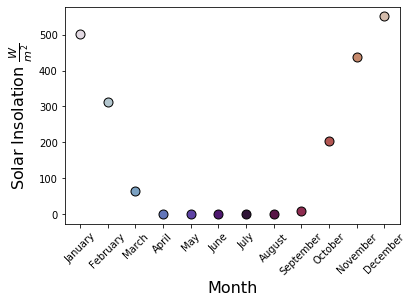

In [129]:
###plot solar insolation by month

fig, ax = plt.subplots(figsize = [6,4])
color=iter(cm.twilight(np.linspace(0,1,13)))

for m in np.array(ds['month']):
    c=next(color)
    plt.plot(m, ram_dict[.00038][m].subprocess.Radiation.insolation, 'o', c = c, mec ='k',ms = 9)
    plt.xticks(rotation = 45)
    plt.xlabel('Month', fontsize = 16)
    plt.ylabel(r'Solar Insolation $\frac{W}{m^2}$', fontsize = 16)
plt.savefig('../figures/solar_insol.png', bbox_inches = 'tight', dpi = 150)

#### absorption coefficients and pressure

In [215]:
# estimate the absorption coefficient for CO2 = 1e-4 m2/kg
# P*CO2 mixing ratio * absorption coefficient / g = 1
# so g/CO2 mixing ratio /absorption coefficient = P

g = 9.8 #m/s2
mmr = 200*1e-6#ppm
abs_coef = 1

P = g/(mmr*abs_coef) #kg*s2/ m
P/100

490.00000000000006

In [207]:
wl = 15 #um
wn = 1/wl * 1e4
wn

666.6666666666666

#### standard atmosphere vs antarctic

In [259]:
#### compare between our antarctic version and a normal atmosphere
alb = 0.25
#  State variables (Air and surface temperature)
state = climlab.column_state(num_lev=30)
#  Parent model process
rcm = climlab.TimeDependentProcess(state=state)
#  Fixed relative humidity
h2o = climlab.radiation.ManabeWaterVapor(state=state)
#  Couple water vapor to radiation
rad = climlab.radiation.RRTMG(state=state, specific_humidity=h2o.q, albedo=alb)
#  Convective adjustment
conv = climlab.convection.ConvectiveAdjustment(state=state, adj_lapse_rate=6.5)
#  Couple everything together
rcm.add_subprocess('Radiation', rad)
rcm.add_subprocess('WaterVapor', h2o)
rcm.add_subprocess('Convection', conv)
#  Run the model
rcm.integrate_years(1)


Opened data from /opt/anaconda3/envs/conda_env/lib/python3.7/site-packages/climlab/radiation/data/ozone/apeozone_cam3_5_54.nc
Integrating for 365 steps, 365.2422 days, or 1 years.
Total elapsed time is 0.9993368783782377 years.


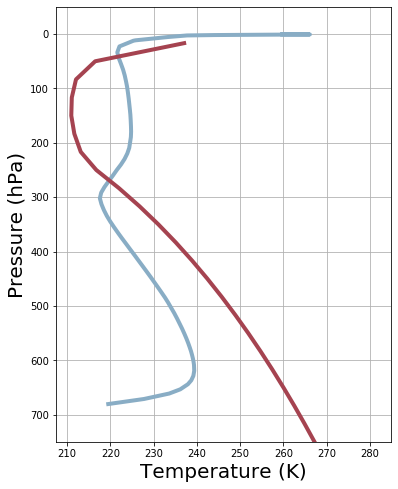

In [263]:
fig, ax = plt.subplots(figsize = [6,8])
colors=cm.twilight(np.linspace(0,1,8))
for month in ['March']:
    #plot our antarctic atmosphere
    x = np.asarray(results_dict[0]['Tatm'][0.00038][month])
    y = results_dict[0]['lev'][0.00038][month]
    plt.plot(x, y, c = colors[1], lw = 4)
    
    #plot standard atmosphere
    plt.plot(rcm.state['Tatm'], rcm.lev, c= colors[5], lw = 4)
    
    #labels and lims
    plt.ylabel('Pressure (hPa)', fontsize = 20)
    plt.xlabel('Temperature (K)', fontsize = 20)
    plt.ylim([750,-50])
plt.grid()
plt.savefig('../figures/stp_antarctic_comp.png', dpi = 150, bbox_inches = 'tight')